In [1]:
!git clone https://github.com/fanzeyi/pokemon.json.git --quiet > /dev/null 2>&1

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import json
import requests
import os
import time
import glob
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from io import BytesIO
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2DTranspose, Reshape
from tensorflow.keras.layers import LeakyReLU, Conv2D, Dropout, Flatten, Add, UpSampling2D
import imageio
from IPython.display import Image as IPyImage, display

In [4]:
# 共通設定
IMG_SIZE = 64
EPOCHS = 3000
noise_dim = 100
num_examples_to_generate = 16

In [5]:
# 1. データ取得

# ポケモン名リスト作成
with open("pokemon.json/pokedex.json", encoding="utf-8") as f:
    pokedex = json.load(f)

pokemon_names = []
for entry in pokedex:
    name = entry["name"]["english"]
    name_url = name.lower().replace(" ", "-").replace(".", "").replace("'", "").replace(":", "").replace("é", "e")
    pokemon_names.append(name_url)

print(f"Total Pokémon: {len(pokemon_names)}")
print(pokemon_names[:10])

Total Pokémon: 809
['bulbasaur', 'ivysaur', 'venusaur', 'charmander', 'charmeleon', 'charizard', 'squirtle', 'wartortle', 'blastoise', 'caterpie']


In [6]:
# ポケモン画像ダウンロード
save_dir = "pokemon_images_full"
os.makedirs(save_dir, exist_ok=True)
base_url = "https://img.pokemondb.net/artwork/large/{}.jpg"

for name in tqdm(pokemon_names, desc="Downloading Pokémon images"):
    url = base_url.format(name)
    response = requests.get(url)
    if response.status_code == 200:
        try:
            img = Image.open(BytesIO(response.content)).convert("RGB")
            img = img.resize((IMG_SIZE, IMG_SIZE), Image.LANCZOS)
            img.save(os.path.join(save_dir, f"{name}.jpg"))
        except:
            continue
    time.sleep(0.5)

print("✅ All Pokémon images downloaded and resized.")

✅ All Pokémon images downloaded and resized.


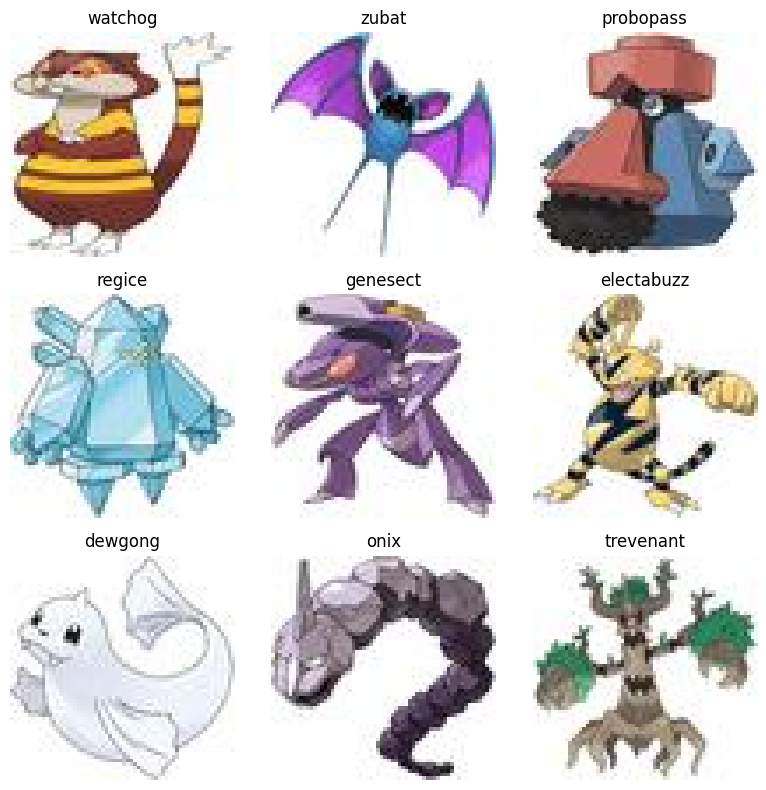

In [7]:
# ダウンロードした画像の確認
image_paths = glob.glob(os.path.join(save_dir, "*.jpg"))
sample_paths = random.sample(image_paths, min(9, len(image_paths)))

plt.figure(figsize=(8, 8))
for i, path in enumerate(sample_paths):
    img = Image.open(path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(path).replace(".jpg", ""))
    plt.axis("off")

plt.tight_layout()
plt.show()

In [8]:
# 2. データ前処理 (train_dataset作成)

# 画像前処理
def preprocess_image(path):
    img = Image.open(path).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img)
    img = (img - 127.5) / 127.5
    return img

image_paths = glob.glob(os.path.join("pokemon_images_full", "*.jpg"))
all_images = np.array([preprocess_image(p) for p in image_paths])

print(f"Loaded {all_images.shape[0]} images, shape: {all_images.shape[1:]}")

BUFFER_SIZE = all_images.shape[0]
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices(all_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Loaded 802 images, shape: (64, 64, 3)


In [9]:
# 3. Generator/Discriminator定義

# Generator用ResBlock
class ResBlockUp(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(ResBlockUp, self).__init__()
        self.upsample = UpSampling2D()
        self.conv1 = Conv2D(filters, (3,3), padding='same')
        self.bn1 = BatchNormalization()
        self.relu1 = LeakyReLU()
        self.conv2 = Conv2D(filters, (3,3), padding='same')
        self.bn2 = BatchNormalization()
        self.shortcut_conv = Conv2D(filters, (1,1), padding='same')
        self.shortcut_bn = BatchNormalization()
        self.relu_out = LeakyReLU()

    def call(self, x, training=True):
        shortcut = self.upsample(x)
        shortcut = self.shortcut_conv(shortcut)
        shortcut = self.shortcut_bn(shortcut, training=training)

        x = self.upsample(x)
        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = Add()([x, shortcut])
        x = self.relu_out(x)
        return x

# Generator
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = Dense(8*8*256, use_bias=False)
        self.bn_fc = BatchNormalization()
        self.relu_fc = LeakyReLU()
        self.reshape = Reshape((8, 8, 256))
        self.resblock1 = ResBlockUp(128)
        self.resblock2 = ResBlockUp(64)
        self.resblock3 = ResBlockUp(32)
        self.conv_final = Conv2D(3, (3,3), padding='same', activation='tanh')

    def call(self, x, training=True):
        x = self.fc(x)
        x = self.bn_fc(x, training=training)
        x = self.relu_fc(x)
        x = self.reshape(x)
        x = self.resblock1(x, training=training)
        x = self.resblock2(x, training=training)
        x = self.resblock3(x, training=training)
        x = self.conv_final(x)
        return x

# Discriminator用ResBlock
class ResBlockDown(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(ResBlockDown, self).__init__()
        self.conv1 = Conv2D(filters, (3,3), strides=2, padding='same')
        self.relu1 = LeakyReLU()
        self.conv2 = Conv2D(filters, (3,3), padding='same')
        self.relu2 = LeakyReLU()
        self.shortcut_conv = Conv2D(filters, (1,1), strides=2, padding='same')

    def call(self, x, training=True):
        shortcut = self.shortcut_conv(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = Add()([x, shortcut])
        x = self.relu2(x)
        return x

# Discriminator
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.resblock1 = ResBlockDown(64)
        self.resblock2 = ResBlockDown(128)
        self.resblock3 = ResBlockDown(256)
        self.flatten = Flatten()
        self.fc = Dense(1)

    def call(self, x, training=True):
        x = self.resblock1(x, training=training)
        x = self.resblock2(x, training=training)
        x = self.resblock3(x, training=training)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [10]:
# 4. Loss/Optimizer/Train関数

# Loss関数
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Model & Optimizer
generator = Generator()
discriminator = Discriminator()
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)

In [11]:
# 5. GAN学習ループ (100エポック毎に進捗画像保存)

# 固定seed → 進捗比較用
fixed_seed = tf.random.normal([num_examples_to_generate, noise_dim])

# 画像保存＋Notebook表示
def generate_and_save_images(model, epoch, seed):
    predictions = model(seed, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        img = (predictions[i, :, :, :] * 127.5 + 127.5).numpy().astype(np.uint8)
        plt.subplot(4, 4, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.savefig(f'pokemon_image_at_epoch_{epoch:04d}.png')
    plt.show()
    plt.close()

# train_step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# train関数 (100エポック毎＋最終のみ保存/出力)
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        # 100エポック毎＋最終時のみ画像保存＋progress log
        if (epoch + 1) % 100 == 0 or (epoch + 1) == epochs:
            generate_and_save_images(generator, epoch + 1, fixed_seed)
            print(f'Epoch {epoch+1}/{epochs} done ✅')

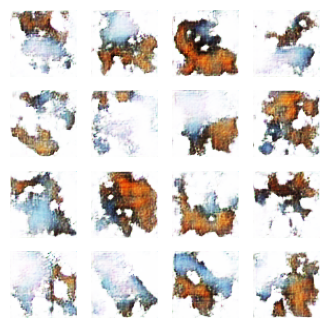

Epoch 100/3000 done ✅


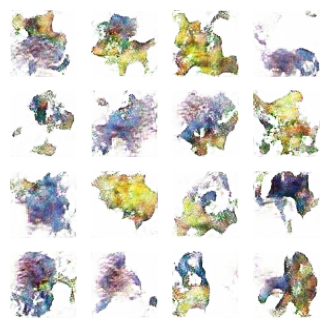

Epoch 200/3000 done ✅


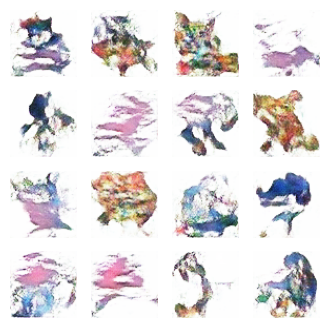

Epoch 300/3000 done ✅


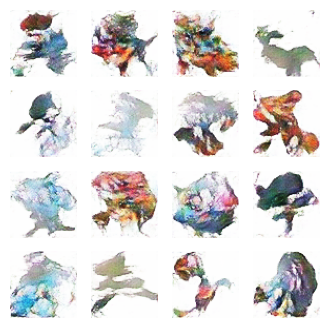

Epoch 400/3000 done ✅


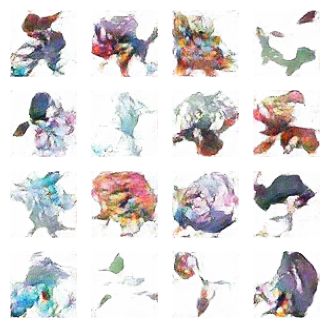

Epoch 500/3000 done ✅


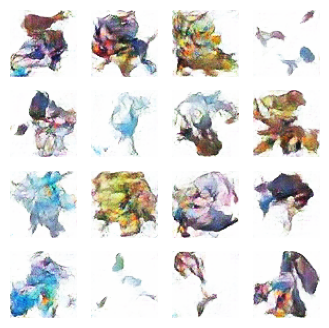

Epoch 600/3000 done ✅


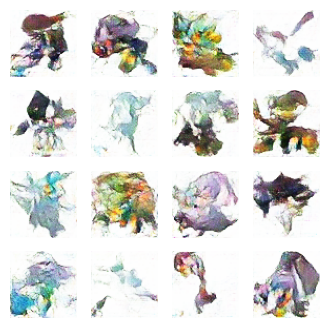

Epoch 700/3000 done ✅


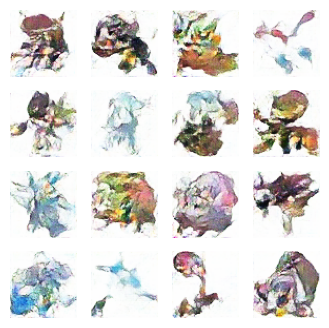

Epoch 800/3000 done ✅


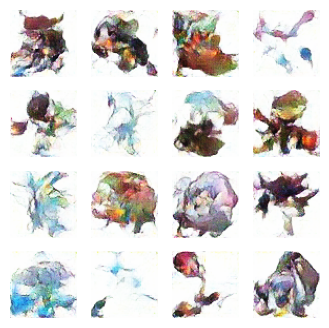

Epoch 900/3000 done ✅


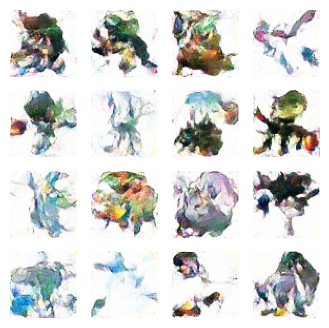

Epoch 1000/3000 done ✅


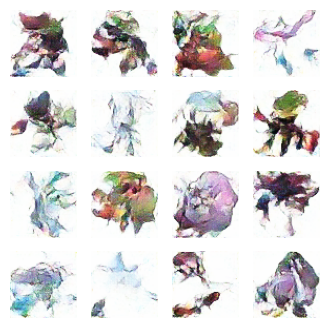

Epoch 1100/3000 done ✅


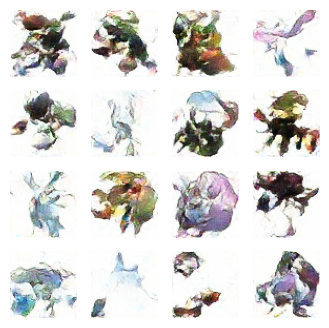

Epoch 1200/3000 done ✅


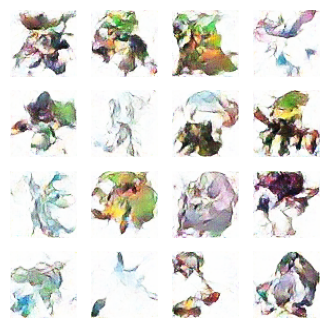

Epoch 1300/3000 done ✅


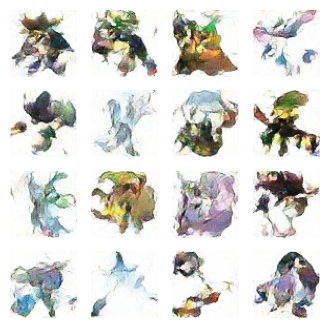

Epoch 1400/3000 done ✅


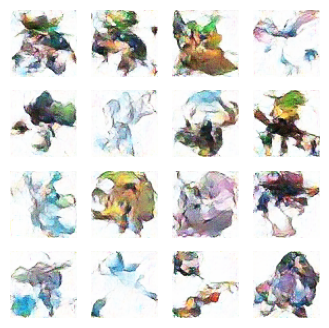

Epoch 1500/3000 done ✅


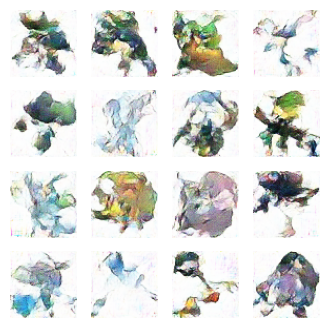

Epoch 1600/3000 done ✅


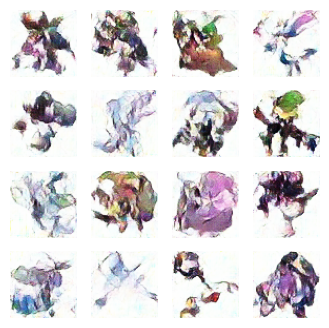

Epoch 1700/3000 done ✅


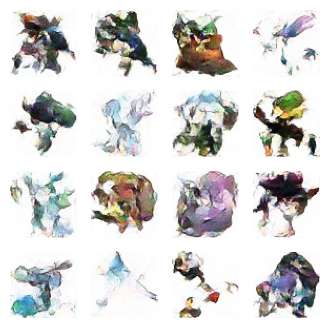

Epoch 1800/3000 done ✅


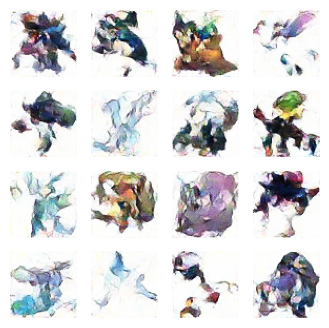

Epoch 1900/3000 done ✅


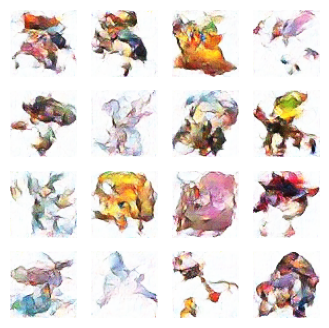

Epoch 2000/3000 done ✅


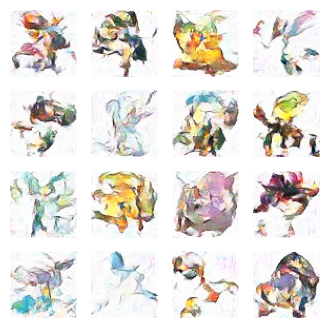

Epoch 2100/3000 done ✅


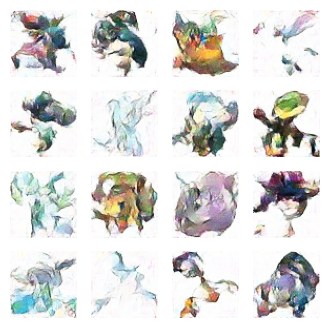

Epoch 2200/3000 done ✅


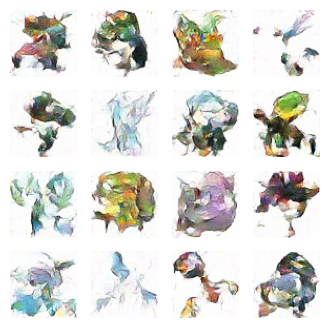

Epoch 2300/3000 done ✅


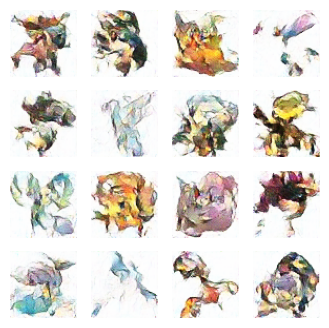

Epoch 2400/3000 done ✅


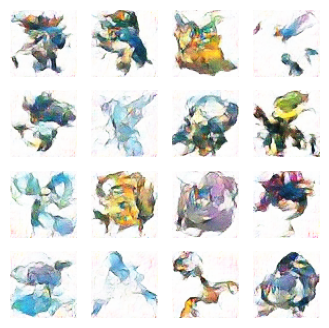

Epoch 2500/3000 done ✅


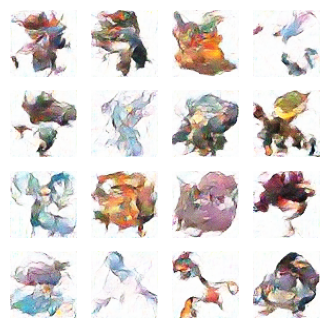

Epoch 2600/3000 done ✅


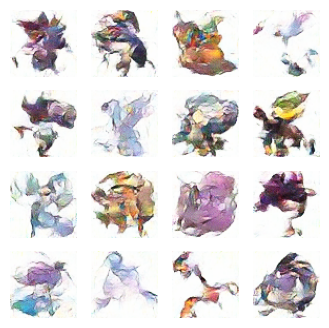

Epoch 2700/3000 done ✅


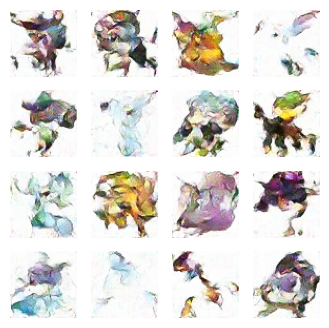

Epoch 2800/3000 done ✅


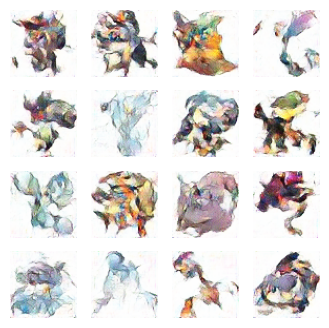

Epoch 2900/3000 done ✅


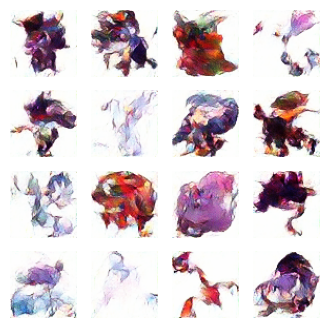

Epoch 3000/3000 done ✅


In [12]:
# 6. 実行
train(train_dataset, EPOCHS)

In [13]:
# 7. GIF作成
from PIL import Image as PILImage

anim_file = 'pokemon_dcgan_github.gif'
filenames = sorted(glob.glob('pokemon_image_at_epoch_*.png'))
gif_size = (128, 128)

frames = []
for filename in filenames:
    pil_img = PILImage.open(filename).resize(gif_size, PILImage.LANCZOS).convert('P', palette=PILImage.ADAPTIVE)
    frames.append(pil_img)

frames[0].save(
    anim_file,
    save_all=True,
    append_images=frames[1:],
    duration=300,    # 各フレーム間 300ms
    loop=0,
    optimize=True    # パレット最適化
)

print(f'GIF saved to {anim_file} ({gif_size[0]}x{gif_size[1]})')

GIF saved to pokemon_dcgan_github.gif (128x128)



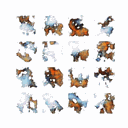

In [15]:
# Notebook内にGIFをBase64で表示
import base64

with open(anim_file, "rb") as f:
    data = f.read()
    encoded = base64.b64encode(data).decode("utf-8")

from IPython.display import HTML, display
display(HTML(f'<img src="data:image/gif;base64,{encoded}" width="300">'))